# Text Classification

*Based on content by [Vilja Hulden](https://programminghistorian.org/en/lessons/naive-bayesian), [Jake VanderPlas](https://colab.research.google.com/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05.05-Naive-Bayes.ipynb), and [Jacob Eisenstein](https://github.com/jacobeisenstein/gt-nlp-class/blob/master/notes/slides/ch02-linear-classification.pdf).*

### Language Models ###
Researchers in natural language processing and related fields use the term *language model* to refer to a mathematical model that assigns a probability to a word (or string) of text. 

We've actually already explored a few of them in this class: topic models and word vector models. Today, we're going to explore another application of language models: text classification. 

### Text Classification ###

The basic problem of text classification is as follows: given a text document, assign it a discrete label y ∈ Y, where Y is the set of possible labels. 

Text classification has many applications, from sentiment analysis (which we've also already performed) to spam filtering (which happens invisbly in our mail systems) to machine translation.

Sentiment analysis: Y = {positive, negative, neutral}

Spam filtering: Y = {spam, not-spam}

Language identification: Y = {Mandarin, English, Spanish, . . .}

Classification is a also building block in more elaborate text analysis tasks, as we'll explore as this unit unfolds. 

Today, we'll be focusing on the most well known (and also easiest!) algorithm for text classification: Naive Bayes. 

Naive Bayes models are a group of extremely fast and simple classification algorithms that are often suitable for very high-dimensional datasets.Because they are so fast and have so few tunable parameters, they end up being very useful as a quick-and-dirty baseline for a classification problem.

## But first, what is classification anyway? ##

Classification is (most commonly) a “supervised” technique, meaning that a person trains the classifier and only then sends it out to classify additional data. (It doesn't have to be textual data, just FYI). The basic training procedure is to give the classifier labeled data: that is, we give it a stack of things (documents, for example) where each of those things is labeled as belonging to a group. This is called training data. The classifier then looks at each item in the training data, looks at its label, and learns what distinguishes the groups from each other. To see how well the classifier has learned, we can then test it by giving it data that is similar to the training data but that the classifier hasn’t seen before and that is not labeled. This is called (you guessed it!) test data. How well the classifier performs on classifying this previously-unseen data is a measure of how well it has learned.

The classic case of a supervised classifier is a program that separates spam from regular email. The classifier is “trained” by giving it a lot of spam (and also regular email) to look at, along with information about which is which. It then builds a statistical model of what a spam message looks like versus what a regular email message looks like. So it learns that a message is more likely to be spam if it contains sexual terms, or words like “offer” and “deal”, or, as things turn out, “ff0000,” the HTML code for red. It can then apply that statistical model to incoming messages and discard the ones it identifies as spam.

Today, we'll build a supervised classifier that we'll train to classify newsgroup contents. We'll give our classifier a set of newsgroup posts along with their correct newsgroups, and then we'll test it on some text that the classifier hasn’t seen, with the hope that it will succeed in guessing the post’s correct classification.

## Bayesian Classification

Naive Bayes classifiers are built on Bayesian classification methods. These rely on Bayes's theorem, which is an equation describing the relationship of conditional probabilities of statistical quantities.

**NOTE:** The “naive” in naive Bayes simply means that the classifier makes the assumption that all the “features” that make up a document are independent of each other. In our case, the features are words, and so the classifier assumes that the occurrence of a particular word is completely independent of the occurrence of another word. This, of course, is often not true, which is why we call it “naive.” For example, when we put “new” and “york” together to form “New York,” the result has a very different meaning than the “new” and “york” in “New clothes for the Prince of York.” If we were to distinguish “New York” from “New” and “York” occurring separately, we might find that each tends to occur in very different types of documents, and thus not identifying the expression “New York” might throw our classifier off course. There are variations on Baysian classification that attempt to take this into account; these are called discriminative learning algoritms and are described [here](https://github.com/jacobeisenstein/gt-nlp-class/blob/master/notes/slides/ch02-linear-classification.pdf).

**NOTE THE SECOND:** Despite their simplistic assumption that the occurrence of any particular feature is independent of the occurrence of other features, Naive Bayesian classifiers do a good enough job to be very useful in many contexts (much of the real-world junk mail detection is performed by Naive Bayesian classifiers, for example). Meanwhile, the assumption of independence means that processing documents is much less computationally intensive, so a Naive Bayesian classifier can handle far more documents in a much shorter time than many other, more complex methods. That in itself is useful. For example, it wouldn’t take too long retrain a Naive Bayesian learner if we accumulated more data. Or we could give it a bigger set of data to begin with; a pile of data that a Naive Bayesian could burrow through in a day might take a more complex method weeks or even months to process. Especially when it comes to classification, more data is often as significant as a better method — as Bob Mercer of IBM famously quipped in 1985, “there is no data like more data.”

In any case, in Bayesian classification, we're interested in finding the probability of a label given some observed features, which we can write as $P(L~|~{\rm features})$.
Bayes's theorem tells us how to express this in terms of quantities we can compute more directly:

$$
P(L~|~{\rm features}) = \frac{P({\rm features}~|~L)P(L)}{P({\rm features})}
$$

If we are trying to decide between two labels—let's call them $L_1$ and $L_2$—then one way to make this decision is to compute the ratio of the posterior probabilities for each label:

$$
\frac{P(L_1~|~{\rm features})}{P(L_2~|~{\rm features})} = \frac{P({\rm features}~|~L_1)}{P({\rm features}~|~L_2)}\frac{P(L_1)}{P(L_2)}
$$

All we need now is some model by which we can compute $P({\rm features}~|~L_i)$ for each label.
Such a model is called a *generative model* because it specifies the hypothetical random process that generates the data.
Specifying this generative model for each label is the main piece of the training of such a Bayesian classifier.
The general version of such a training step is a very difficult task, but we can make it simpler through the use of some simplifying assumptions about the form of this model.

This is (again) where the "naive" in "naive Bayes" comes in: if we make very naive assumptions about the generative model for each label, we can find a rough approximation of the generative model for each class, and then proceed with the Bayesian classification.
Different types of naive Bayes classifiers rest on different naive assumptions about the data, and we will examine two of these.

We begin with the standard imports:

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

## Wrapping our Heads around Generative Models

### Gaussian Naive Bayes

Perhaps the easiest naive Bayes classifier to understand is Gaussian naive Bayes.
In this classifier, the assumption is that *data from each label is drawn from a simple Gaussian distribution*.
Imagine that you have the following data:

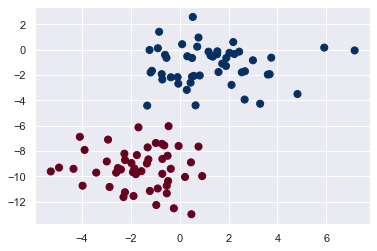

In [3]:
from sklearn.datasets import make_blobs
X, y = make_blobs(100, 2, centers=2, random_state=2, cluster_std=1.5)
plt.scatter(X[:, 0], X[:, 1]
            , c=y, s=50, cmap='RdBu');

One extremely fast way to create a simple model is to assume that the data is described by a Gaussian distribution with no covariance between dimensions.
This model can be fit by simply finding the mean and standard deviation of the points within each label, which is all you need to define such a distribution.
The result of this naive Gaussian assumption is shown in the following figure:

![(run code in Appendix to generate image)](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/figures/05.05-gaussian-NB.png?raw=1)

The ellipses here represent the Gaussian generative model for each label, with larger probability toward the center of the ellipses.
With this generative model in place for each class, we have a simple recipe to compute the likelihood $P({\rm features}~|~L_1)$ for any data point, and thus we can quickly compute the posterior ratio and determine which label is the most probable for a given point.

This procedure is implemented in Scikit-Learn's ``sklearn.naive_bayes.GaussianNB`` estimator:

In [4]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(X, y);


Now let's generate some new data and predict the label:

In [5]:
rng = np.random.RandomState(0)
Xnew = [-6, -14] + [14, 18] * rng.rand(2000, 2)
ynew = model.predict(Xnew)

Now we can plot this new data to get an idea of where the decision boundary is:

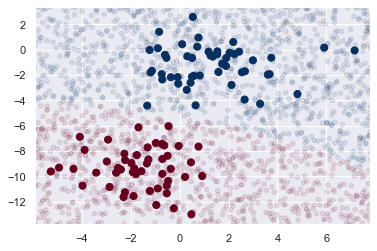

In [6]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='RdBu')
lim = plt.axis()
plt.scatter(Xnew[:, 0], Xnew[:, 1], c=ynew, s=20, cmap='RdBu', alpha=0.1)
plt.axis(lim);

We see a slightly curved boundary in the classifications—in general, the boundary in Gaussian naive Bayes is quadratic.

Of course, the final classification will only be as good as the model assumptions that lead to it, which is why Gaussian naive Bayes often does not produce very good results.

Still, in many cases—especially as the number of features becomes large—this assumption is not detrimental enough to prevent Gaussian naive Bayes from being a useful method.

## Multinomial Naive Bayes

The Gaussian assumption just described is by no means the only simple assumption that could be used to specify the generative distribution for each label. Another useful example is multinomial naive Bayes, where the features are assumed to be generated from a simple multinomial distribution. The multinomial distribution describes the probability of observing counts among a number of categories, and thus multinomial naive Bayes is most appropriate for features that represent word counts (or other frequencies within the documents to be classified).

The idea is precisely the same as before, except that instead of modeling the data distribution with the best-fit Gaussian, we model the data distribuiton with a best-fit multinomial distribution.

### A Generative Story

The fundamental assumption we make in generating our multinomial distribution is that documents come into being not as a result of intellectual cogitation but as a result of a process whereby words are picked at random out of a bag and then put into a document (this is the bag-of-words model that we've referenced throughout the course).

In other words: the assumption is that novels, for example, are written in something like the following manner. Each author has his or her own bag of words with a vocabulary specific to that bag. So when Ann the Novelist writes a book, what she does is this:

* She goes to the bag that is her store of words.
* She puts her hand in and pulls out a piece of paper.
* She reads the word on the piece of paper, writes it down in her book, and puts the paper back in the bag.
* Then she again puts her hand in the bag and pulls out a piece of paper.
* She writes down that word in the book, and puts the piece of paper back in the bag.

Ann the Novelist keeps going until she decides her book (or article, or blog post, or whatever) is finished. The next time she wants to write something, she goes back to her bag of words and does the same thing. 

If her friend John the Novelist were to write a book, he would go to his own bag, which has a different set of words, and then he would follow the same procedure of taking out a word, writing it down, putting it back in. It’s just one damn word after another.

So let’s say you are a librarian, and one day you discover a huge forgotten trunk of books in the basement of the library. It turns out that the trunk contains dozens and dozens of typed book manuscripts. After some digging, you find a document that explains that these are transcripts of unpublished book drafts by three novelists: JK Rowling, NK Jemison, and Tayari Jones. (NB: These are three actual novelists; Jones teaches at Emory).

What a find! But unfortunately, as you begin sorting through the drafts, you realize that they are not marked with the author’s name. What can you do? How can you classify them correctly?

Well, you do have other novels by these authors. And if novelists write their books in the manner described above — if each novelists has their own bag of words with a particular vocabulary and a particular distribution of words — then we can figure out who wrote each document by looking at the words it contains and comparing the distribution of those words to the distribution of words in documents we know were written by Rowling, Jemison, and Jones, respectively.

So you go to Woodruff and get out all the books by Rowling, Jemison, and Jones. Then you start counting. You start with JK Rowling. For each word in a work by Rowling, you add the word to a list marked “Rowling.” If the word is already in the list, you add to its count. Then you do the same with the works of Jemison and Jones. Finally, for each author, you add up the total number of words you’ve seen. You also add up the total number of books you have examined so you’ll have a metric for how much work each author has published.

So what you end up with is something like this:

| Rowling (5) |	Jemison (18) | Jones (2)
| --- | --- | --- |
| wizard, 985 |	fire, 756| love, 989 |
| spell, 897 | obelisk, 699|		school, 920 |
| cat, 887 |	stone, 613 |	atlanta, 899 |
| …|	…	|…|
|(total), 352,003	| (total), 745,532	| (total), 300,487 }

What you have done, in essence, is to reconstruct each novelist’s “bag of words” — now you know (at least approximately) what words each writer uses and in what proportions. Armed with this representation of the word distributions in the works of Rowling, Jemison, and Jones, you’re ready to tackle the task of figuring out who wrote which manuscripts.

You’re going to work manuscript by manuscript and author by author, first pretending that the manuscript you’re currently considering was written by Rowling, then that it was written by Jemison, and so on. For each author, you calculate how likely it is that the manuscript really was written by that author.

So with your first manuscript in hand, you start by assuming that the manuscript was written by Rowling. First you figure out the overall probability of any book being written by Rowling rather than either of the two others — that is, of the Rowling bag rather than the Jemison bag or the Jones bag being used to produce a book. You do this by taking the number of books written by Rowling and dividing it by the total number of books written by all these authors.

That comes out to 5/(5 + 18 + 2), or 0.2 (20 percent).

Then, you start looking at the words in the manuscript. Let’s say the first word is “cat.” You check how often that word occurred in Rowling’ published oeuvre, and you find that the answer is 887. Then you check how many words, overall, there were in Rowling’ total works, and you note that the answer is 352,003. You divide 887 by 352,003 to get the proportional frequency (call it p) of “cat” in Rowling’ work (0.0025). For the next word, you do the same procedure, and then multiply the probabilities together (you multiply since each action — picking an author, or picking a word — represents an independent choice). In the end you end with a tally like this:

`p_bag * p_word_1 * p_word_2 * ... * p_word_n`

Note that including the probability of picking the bag (p_bag) is an important step: if you only go by the words in the manuscript and ignore how many manuscripts (or rather, published works) each author has written, you can easily go wrong. If Jemison has written ten times the number of books that Jones has, it should reasonably require much firmer evidence in the form of an ample presence of “Jonsian” words to assume that a manuscript was written by Jones than that it was written by Jemison. 

OK, so now you have a total probability of the manuscript having been written by Rowling. Next, you repeat the whole procedure with the assumption that maybe it was instead written by Jemison (that is, that it came out of the bag of words that Jemison used when writing). That done, you move on to considering the probability that the author was Jones (and if you had more authors, or categories, or whatever, you’d keep going until you had covered each of them).

But in this case, when you’re done, you have only three total probabilities — one probability per author. Then you just pick out the largest one, and that’s the author who most probably wrote this manuscript.

**NOTE:** When calculating

`p_bag * p_word1 * ... * p_word_n`

in a software implementation we actually work with the logarithms of the probabilities since the numbers easily become very small. When doing this, we actually calculate:

`log(p_bag) + log(p_word1) + ... + log(p_word_n)`

That is, our multiplications turn into additions in line with the rules of logarithms. But it all works out right: the class with the highest number at the end still wins.)

But wait! What if the manuscript contains a word that we’ve never seen Rowling use before, but also lots of words he used all the time? Won’t that throw off our calculations?

Indeed. We shouldn’t let outliers throw us off the scent. So we do something very “Bayesian”: we put a “prior” on each word and each class — we pretend we’ve seen all imaginable words at least (say) once in each bag, and that each bag has produced at least (say) one document. Then we add those fake pretend counts — called priors, or pseudocounts — to our real counts. Now, no word or bag gets a count of zero.

In fact, we can play around with the priors as much as we like: they’re simply a way of modeling our “prior belief” in the probability of one thing over another. They could model our assumptions about a particular author being more likely than others, or a particular word being more likely to have come from the bag of a specific author, and so on. Such beliefs are “prior” in the sense that we hold the belief before we’ve seen the evidence we are considering in the actual calculation we are making. So above, for example, we could add a little bit to Tayari Jones’s p_bag number if we thought it likely that as a professor as well as a writer, she might have not have as much time as the others to finish additional projects, and so there might reasonably be more manuscript material from her than one might infer from a count of her published books.

In some cases, priors can make a Naive Bayesian classifier much more usable. Often when we’re classifying, after all, we’re not after some abstract “truth” — rather, we simply want a useful categorization. In some cases, it’s much more desirable to be mistaken one way than another, and we can model that with proper class priors. The classic example is, again, sorting email into junk mail and regular mail piles. Obviously, you really don’t want legitimate messages to be deleted as spam; that could do much more damage than letting a few junk messages slip through. So you set a big prior on the “legitimate” class that causes your classifier to only throw out a message as junk when faced with some hefty evidence. By the same token, if you’re sorting the results of a medical test into “positive” and “negative” piles, you may want to weight the positive more heavily: you can always do a second test, but if you send the patient home telling them they’re healthy when they’re not, that might not turn out so well.

So there you have it, step by step. You have applied a Naive Bayesian to the unattributed manuscripts, and you now have three neat piles. Of course, you should keep in mind that Naive Bayesian classifiers are not perfect either, so you may want to do some further research before entering the newfound materials into the library catalog as works by Rowling, Jemison, and Jones, respectively.

## Enough hypotheticals. Let's get to it! 

I've spent a lot of time on this hypthetical scenario because the reality is that scikit-learn has naive Bayes classification all figured out. You barely need to do a thing! 

Here we will use the sparse word count features from the 20 Newsgroups corpus that is part of scikit-learn to show how we might classify some documents into categories.

Let's download the data and take a look at the possible categories:

In [7]:
from sklearn.datasets import fetch_20newsgroups

data = fetch_20newsgroups()
data.target_names # gets us the names of the newsgroups

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

For simplicity here, we will select just a few of these categories, and download the training and testing set built into this data package:

In [8]:
categories = ['rec.autos', 'rec.motorcycles',
              'sci.space', 'comp.graphics']
train = fetch_20newsgroups(subset='train', categories=categories) # quickly make a train dataset
test = fetch_20newsgroups(subset='test', categories=categories) # quickly make a test dataset

### A note on training and testing 

In truth, I'm not entirely sure how sklearn creates the training data and the test data. I'm guessing that it uses the standard 80-20 ratio, and that you can probably adjust that with some paramaters.

Later, we'll discuss a (slightly) more sophisticated method of training and testing: namely, cross-validation. Cross-validation simply means repeatedly splitting your data into chunks, rather than simply using a single train/test split. This avoids the possibliity that your test results are not the consequence of some oddball quirk in the portion of data you left for testing.

In any case, here is a representative entry from the training data:

In [12]:
print(train.data[5])

From: leavitt@cs.umd.edu (Mr. Bill)
Subject: Re: Countersteering_FAQ please post
Organization: The Cafe at the Edge of the Universe
Lines: 43

mjs@sys.uea.ac.uk (Mike Sixsmith) writes:
mjs>Secondly, it is the adhesion of the
mjs>tyre on the road, the suspension geometry  and the ground clearance of the
mjs> motorcycle which dictate how quickly you can swerve to avoid obstacles, and
mjs>not the knowledge of physics between the rider's ears. Are you seriously
            ^^^^^^^^^^^^^^^^^^^^
mjs>suggesting that countersteering knowledge enables you to corner faster
mjs>or more competentlY than you could manage otherwise??

egreen@east.sun.com writes:
ed>If he's not, I will.  

Hey Ed, you didn't give me the chance!  Sheesh!

The answer is, absolutely!, as Ed so eloquently describes:

ed>Put two riders on identical machines.  It's the
ed>one who knows what he's doing, and why, that will be faster.  It *may*
ed>be possible to improve your technique if you have no idea what it is,
ed>throug

In order to use these data in our classifier, we need to be able to convert the content of each string into a vector of numbers. We can either use a simple BoW model, as described above, or we can use TF-IDF. 

In this case, since we're most interested in classifying according to the contents of the newsgroups, we'll use TF-IDF. (For classifiers that are more intereted in linguistic style, BoW models usually work better).

So for this classifier we will use the TF-IDF vectorizer, which we've used before, and create a pipeline -- a scikit-learn feature that does what it sounds like -- that attaches it to a multinomial naive Bayes classifier:

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline

model = make_pipeline(TfidfVectorizer(), MultinomialNB())

With this pipeline, we can apply the model to the training data, and predict labels for the test data:

In [10]:
model.fit(train.data, train.target)
labels = model.predict(test.data)

Now that we have predicted the labels for the test data, we can evaluate them to learn about the performance of the estimator.
For example, here is the confusion matrix between the true and predicted labels for the test data:

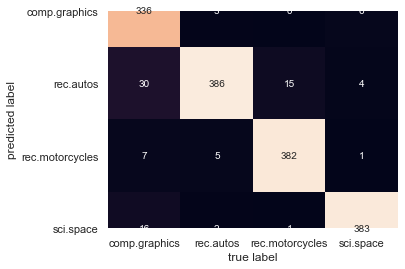

In [11]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(test.target, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=train.target_names, yticklabels=train.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

Evidently, even this very simple classifier can separate space talk from computer talk (not surprising), as well as car talk from motorcycle talk (which I'd guess would be harder). 

The very cool thing here is that we now have the tools to determine the category for *any* string, using the ``predict()`` method of this pipeline.

Here's a quick utility function that will return the prediction for a single string:

In [12]:
def predict_category(s, train=train, model=model):
    pred = model.predict([s])
    return train.target_names[pred[0]]

Let's try it out:

In [13]:
predict_category('sending a payload to the ISS')

'sci.space'

In [14]:
predict_category('discussing whether or not to wear a helmet')

'rec.motorcycles'

In [15]:
predict_category('determining the screen resolution')

'comp.graphics'

Remember that this is nothing more sophisticated than a simple probability model for the (weighted) frequency of each word in the string; nevertheless, the result is striking.
Even a very naive algorithm, when used carefully and trained on a large set of high-dimensional data, can be surprisingly effective.

## The uses of outliers ##

TK

## Measures of classification ##

The basic measure of classification prowess is accuracy: how often did classifier guess the class of a document correctly? This is calculated by simply dividing the number of correct guesses by the total number of documents considered.

But oftentimes, we’re interested in a specific category-- for example, how well the classifier did with respect to the “comp.graphics” category, above, in particular.

So if we’re considering a single category, we need a few more numbers: first, how many trials belonging to the category -- say “comp.graphics” -- there are in our test sample; second, how many times we’ve guessed that a trial belongs to the “comp.graphics” category; and third, how many times we have guessed correctly that a trial belongs to “comp.graphics."

Now that we have this information, we can use it to calculate a couple of standard measures of classification efficiency: precision and recall. Precision tells us how often we correctly guessed that a trial was in the “comp.graphics” category. Recall lets us know what proportion of the “comp.graphics” trials we caught, as so:

In [16]:
from sklearn.metrics import classification_report
report = classification_report(test.target, labels, target_names=train.target_names)

print(report) # f1-score is harmonic mean of precision and recall


                 precision    recall  f1-score   support

  comp.graphics       0.97      0.86      0.92       389
      rec.autos       0.89      0.97      0.93       396
rec.motorcycles       0.97      0.96      0.96       398
      sci.space       0.95      0.97      0.96       394

       accuracy                           0.94      1577
      macro avg       0.95      0.94      0.94      1577
   weighted avg       0.95      0.94      0.94      1577



### Precision and Recall Explained ###

Let’s take another hypothetical example to clarify precision and recall. Imagine you want all the books on a particular topic — World War I, say — from Woodruff. You send out one of your students to get the books. The students dutifully returns with a big pile.

Now, suppose you were in possession of a list that contained of every single book in the library on WWI and no books that weren’t related to the WWI. You could then check the precision and recall of your student with regard to the category of “books on WWI.”

Recall is the term for the proportion of books on WWI in the library that your student managed to grab. That is, the more books on WWI remaining in the library after your minion’s visit, the lower your minion’s recall.

Precision, in turn, is the term for the proportion of books in the pile brought by your student that actually had to do with WWI. The more irrelevant (off-topic) books in the pile, the lower the precision.

So, say the library has 1,000 books on WWI, and your student lugs you a pile containing 400 books, of which 300 have nothing to do with WWI. The student’s recall would be (400-300)/1,000, or 10 percent. The student’s precision, in turn, would be (400-300)/400, or 25 percent.

(Should have gone yourself, eh?)

## When to Use Naive Bayes

Because naive Bayesian classifiers make such stringent assumptions about data, they will generally not perform as well as a more complicated model.
That said, they have several advantages:

- They are extremely fast for both training and prediction
- They provide straightforward probabilistic prediction
- They are often very easily interpretable
- They have very few (if any) tunable parameters

These advantages mean a naive Bayesian classifier is often a good choice as an initial baseline classification.
If it performs suitably, then congratulations: you have a very fast, very interpretable classifier for your problem.
If it does not perform well, then you can begin exploring more sophisticated models, with some baseline knowledge of how well they should perform.

Naive Bayes classifiers tend to perform especially well in one of the following situations:

- When the naive assumptions actually match the data (very rare in practice)
- For very well-separated categories, when model complexity is less important
- For very high-dimensional data, when model complexity is less important

The last two points seem distinct, but they actually are related: as the dimension of a dataset grows, it is much less likely for any two points to be found close together (after all, they must be close in *every single dimension* to be close overall).
This means that clusters in high dimensions tend to be more separated, on average, than clusters in low dimensions, assuming the new dimensions actually add information.
For this reason, simplistic classifiers like naive Bayes tend to work as well or better than more complicated classifiers as the dimensionality grows: once you have enough data, even a simple model can be very powerful.